In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import pickle

In [18]:
from xgboost import XGBClassifier
print("XGBoost imported successfully!")

XGBoost imported successfully!


In [19]:
df=pd.read_csv('https://raw.githubusercontent.com/Sarthak-Chalia/crop_reccomendation_dataset/refs/heads/main/Crop_Recommendation.csv')


In [20]:
required_cols = ['Nitrogen', 'Phosphorus', 'Potassium', 'pH_Value', 'Rainfall', 'Humidity', 'Temperature', 'Crop']
assert all(col in df.columns for col in required_cols), "Missing required columns!"

In [21]:
df = df.dropna()

In [22]:
X = df[required_cols[:-1]]  # All except 'crop'
y = df['Crop']

In [23]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [24]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns  # Preserve original column names
)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, 
    y_encoded, 
    test_size=0.2, 
    random_state=42
)

In [26]:
assert set(X_train.columns) == set(X_test.columns), "Feature mismatch!"

In [27]:
model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss'
)

model.fit(X_train, y_train)

,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


Accuracy: 0.9840909090909091

Classification Report:
              precision    recall  f1-score   support

       Apple       1.00      1.00      1.00        23
      Banana       1.00      1.00      1.00        21
   Blackgram       0.95      1.00      0.98        20
    ChickPea       1.00      1.00      1.00        26
     Coconut       1.00      1.00      1.00        27
      Coffee       1.00      1.00      1.00        17
      Cotton       0.94      1.00      0.97        17
      Grapes       1.00      1.00      1.00        14
        Jute       0.92      0.96      0.94        23
 KidneyBeans       1.00      1.00      1.00        20
      Lentil       0.92      1.00      0.96        11
       Maize       1.00      0.95      0.98        21
       Mango       0.95      1.00      0.97        19
   MothBeans       1.00      0.96      0.98        24
    MungBean       1.00      1.00      1.00        19
   Muskmelon       1.00      1.00      1.00        17
      Orange       1.00     

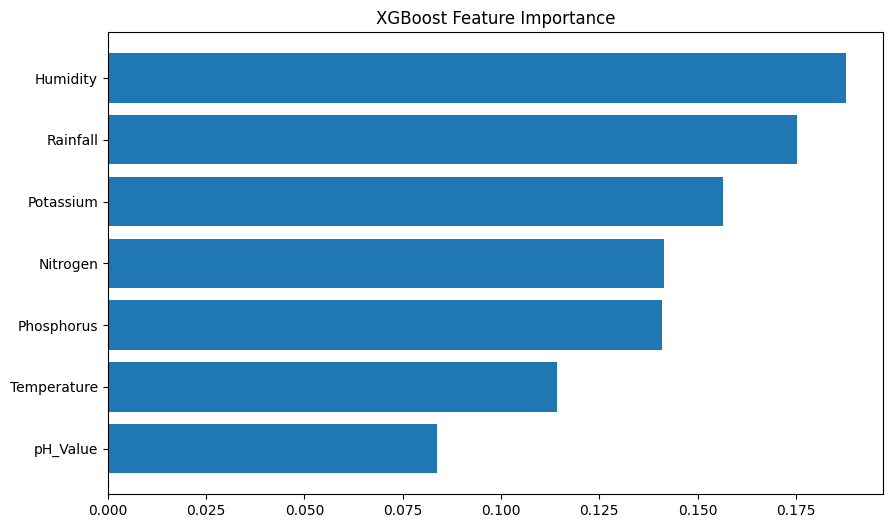

In [28]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Feature importance plot (with correct labels)
plt.figure(figsize=(10, 6))
sorted_idx = model.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.title("XGBoost Feature Importance")
plt.show()

In [29]:
model_data = {
    'model': model,
    'scaler': scaler,
    'label_encoder': le,
    'feature_names': list(X.columns),  # Original column order
    'required_features': required_cols[:-1]
}

with open('crop_recommender.pkl', 'wb') as f:
    pickle.dump(model_data, f)


In [30]:
def recommend_crop(input_dict):
    """
    Args:
        input_dict: Dict with keys: nitrogen, phosphorus, potassium, 
                   ph, rainfall, humidity, temperature
    Returns:
        Crop name (str)
    """
    # Convert input to DataFrame (preserving feature order)
    input_df = pd.DataFrame([input_dict], columns=model_data['feature_names'])
    
    # Scale features
    input_scaled = pd.DataFrame(
        model_data['scaler'].transform(input_df),
        columns=input_df.columns
    )
    
    # Predict and decode label
    pred_num = model_data['model'].predict(input_scaled)[0]
    return model_data['label_encoder'].inverse_transform([pred_num])[0]